<div><span style="background-color: #9e4244; padding-top: 80px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: white; font-size: 22px; font-weight: bold">Random Forest with Resampling</span></div>

In [1]:
# General Libraries
import re
import time
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score)

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours) 
from imblearn.combine import SMOTETomek, SMOTEENN

# SHAP
import shap

In [2]:
!pip install termcolor


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
df = pd.read_csv('cc_df.csv', nrows=100000)
df.head()

,lat,long,city_pop,trans_date,amt,is_fraud,merch_lat,merch_long,trans_day,city_Angeles City,...,part_of_day_lunch,region_CALABARZON,region_NCR,region_Region 3,quarantine_status_ECQ,quarantine_status_GCQ,quarantine_status_MECQ,quarantine_status_Normal,QL_Extreme QL,QL_Moderate-Low QL
0,14.5958,120.9772,23088000,2020-09-13,966.24,1,14.133430,121.223118,13,0,...,1,0,1,0,0,1,0,0,0,1
1,14.5958,120.9772,23088000,2020-09-13,275.37,1,15.290354,120.246084,13,0,...,0,0,1,0,0,1,0,0,0,1
2,14.5958,120.9772,23088000,2020-09-14,326.96,1,15.402101,121.332516,14,0,...,0,0,1,0,0,1,0,0,0,1
3,14.5958,120.9772,23088000,2020-09-14,1047.59,1,15.166276,121.955649,14,0,...,0,0,1,0,0,1,0,0,0,1
4,14.5958,120.9772,23088000,2020-09-14,286.34,1,15.149144,121.696662,14,0,...,0,0,1,0,0,1,0,0,0,1


In [10]:
df = df.drop(['trans_date'], axis=1)

In [11]:
df.head()

,lat,long,city_pop,amt,is_fraud,merch_lat,merch_long,trans_day,city_Angeles City,city_Antipolo,...,part_of_day_lunch,region_CALABARZON,region_NCR,region_Region 3,quarantine_status_ECQ,quarantine_status_GCQ,quarantine_status_MECQ,quarantine_status_Normal,QL_Extreme QL,QL_Moderate-Low QL
0,14.5958,120.9772,23088000,966.24,1,14.133430,121.223118,13,0,0,...,1,0,1,0,0,1,0,0,0,1
1,14.5958,120.9772,23088000,275.37,1,15.290354,120.246084,13,0,0,...,0,0,1,0,0,1,0,0,0,1
2,14.5958,120.9772,23088000,326.96,1,15.402101,121.332516,14,0,0,...,0,0,1,0,0,1,0,0,0,1
3,14.5958,120.9772,23088000,1047.59,1,15.166276,121.955649,14,0,0,...,0,0,1,0,0,1,0,0,0,1
4,14.5958,120.9772,23088000,286.34,1,15.149144,121.696662,14,0,0,...,0,0,1,0,0,1,0,0,0,1


Would Recommend:       0
1    300
0  29677
Proportion Chance Criterion: 98.02%
1.25 * Proportion Chance Criterion: 122.52%


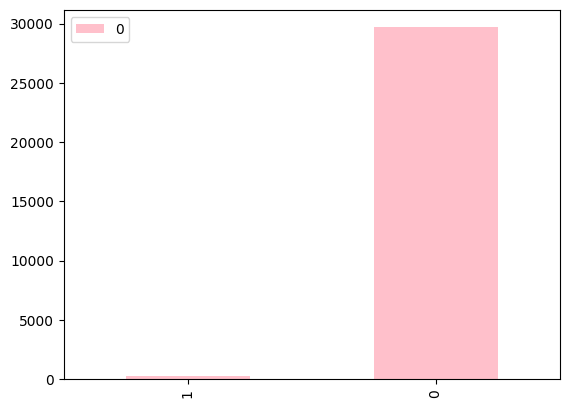

In [13]:
state_counts = Counter(df['is_fraud'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar', color='pink')

num=(df_state[0]/df_state[0].sum())**2

print("Would Recommend:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

In [14]:
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                  random_state=11, test_size=0.25,
                                                                  stratify=y)

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Auto-ML </span></div>

In [15]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {}
    results2 = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        train_scores = []
        val_scores = []

        train_recall = []
        val_recall = []

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))

            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]


### Baseline

In [16]:
models_dict = {'RandomForestClassifier': RandomForestClassifier(random_state=143)}

# models_dict = {
#     'KNeighborsClassifier': KNeighborsClassifier(),
#     'LogisticRegressor': LogisticRegression(),
#     'GaussianNB': GaussianNB(),
#     'RandomForestClassifier': RandomForestClassifier(random_state=143),
#     'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143),
#     'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)   
# }

In [17]:
auto_run = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
               cv=StratifiedKFold(n_splits=5))
auto = auto_run[0]
auto_run[1]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
RandomForestClassifier,2.389929,100.00%,100.00%,99.60%,60.89%


### Applying resampling techniques

#### Oversampling

In [19]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN()),
           ('BorderlineSMOTE', BorderlineSMOTE()),
           ('SVMSMOTE', SVMSMOTE())]

outputs = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                    cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

---------------------------------------------------SMOTE---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.15737247467041016
Resampling done in 0.14631223678588867
Resampling done in 0.14251708984375
Resampling done in 0.1597888469696045
Resampling done in 0.15678048133850098


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
RandomForestClassifier,7.253619,100.00%,100.00%,99.58%,59.11%


--------------------------------------------------ADASYN---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.2029719352722168
Resampling done in 0.20195794105529785
Resampling done in 0.20296716690063477
Resampling done in 0.22234392166137695
Resampling done in 0.19800496101379395


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
RandomForestClassifier,6.917126,100.00%,100.00%,99.60%,61.78%


----------------------------------------------BorderlineSMOTE----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.21108078956604004
Resampling done in 0.19727277755737305
Resampling done in 0.20151734352111816
Resampling done in 0.21440339088439941
Resampling done in 0.20045733451843262


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
RandomForestClassifier,7.062443,100.00%,100.00%,99.60%,60.44%


-------------------------------------------------SVMSMOTE--------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 2.707989454269409
Resampling done in 2.698535203933716
Resampling done in 2.6147425174713135
Resampling done in 2.7198069095611572
Resampling done in 2.771730899810791


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
RandomForestClassifier,6.550133,100.00%,100.00%,99.60%,60.44%


#### Undersampling

In [26]:
res_list = [('TomekLinks', TomekLinks()),
            ('NearMiss', NearMiss()),
            ('AllKNN', AllKNN()),
            ('ENN', EditedNearestNeighbours()),
            ('RENN', RepeatedEditedNearestNeighbours())
           ]

outputs_u = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

------------------------------------------------TomekLinks-------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 2.046755075454712
Resampling done in 1.9890012741088867
Resampling done in 2.002711534500122
Resampling done in 1.968385934829712
Resampling done in 1.9833362102508545


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
RandomForestClassifier,3.347823,100.00%,100.00%,99.59%,60.00%


-------------------------------------------------NearMiss--------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.10396862030029297
Resampling done in 0.10485577583312988
Resampling done in 0.09148192405700684
Resampling done in 0.09246301651000977
Resampling done in 0.09287238121032715


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
RandomForestClassifier,0.22748,100.00%,100.00%,71.12%,92.44%


--------------------------------------------------AllKNN---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 5.996028423309326
Resampling done in 7.07584023475647
Resampling done in 6.564208507537842
Resampling done in 6.225716590881348
Resampling done in 6.0755016803741455


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
RandomForestClassifier,3.892331,100.00%,100.00%,99.60%,60.44%


----------------------------------------------------ENN----------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 2.1554272174835205
Resampling done in 2.081875801086426
Resampling done in 2.1999411582946777
Resampling done in 2.1456964015960693
Resampling done in 2.0781161785125732


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
RandomForestClassifier,3.322835,100.00%,100.00%,99.56%,56.89%


---------------------------------------------------RENN----------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 7.891374826431274
Resampling done in 10.034526586532593
Resampling done in 11.11079216003418
Resampling done in 8.801775217056274
Resampling done in 10.253798723220825


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
RandomForestClassifier,3.19654,100.00%,100.00%,99.63%,62.67%


#### Combined Resampling

In [25]:
res_list = [('SMOTETomek', SMOTETomek()),
            ('SMOTEENN', SMOTEENN())]

outputs_u = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

------------------------------------------------SMOTETomek-------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 7.394899845123291
Resampling done in 7.917503118515015
Resampling done in 8.177938222885132
Resampling done in 9.087428092956543
Resampling done in 10.686429500579834


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
RandomForestClassifier,7.832121,100.00%,100.00%,99.57%,58.22%


-------------------------------------------------SMOTEENN--------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 8.066046237945557
Resampling done in 8.847952604293823
Resampling done in 8.599715948104858
Resampling done in 8.61014699935913
Resampling done in 8.006133317947388


,Run Time,Train Accuracy,Train Recall,Val Accuracy,Val Recall
RandomForestClassifier,7.227464,100.00%,100.00%,99.62%,64.00%


<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Grid-Search and Randomized Search Cross Validation </span></div>

[Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [Randomized Search Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) are commonly used to hypertune models across multiple parameters

#### Base-case